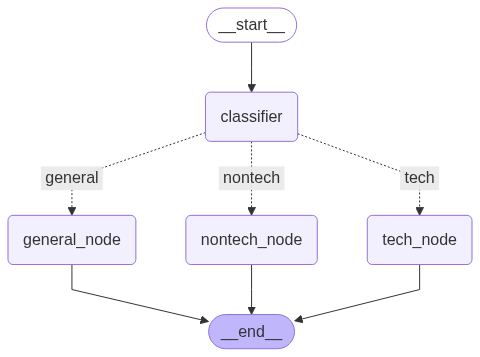

In [17]:
from langgraph.graph import StateGraph, END, START
from utils.model_loader import get_llm
from Agents.tech_agent import handle_tech_question
from Agents.nontech_agent import handle_nontech_question
from Agents.general_agent import handle_general_question
from langchain_core.runnables import RunnableLambda

# Load the language model
llm = get_llm()

# Define the shared state
class ChatState(dict):
    question: str
    response: str
    intent: str


# Classifier function (returns a dictionary)
def classify_intent(state: ChatState) -> ChatState:
    q = state["question"].lower()
    if any(word in q for word in ["python", "code", "ai", "ml", "data", "programming"]):
        state["intent"] = "tech"
    elif any(word in q for word in ["movie", "travel", "news", "food"]):
        state["intent"] = "general"
    else:
        state["intent"] = "nontech"
    return state


# Agent Nodes
def tech_node(state: ChatState) -> dict:
    return {"response": handle_tech_question(state["question"], llm)}

def nontech_node(state: ChatState) -> dict:
    return {"response": handle_nontech_question(state["question"], llm)}

def general_node(state: ChatState) -> dict:
    return {"response": handle_general_question(state["question"], llm)}

# Build the LangGraph
builder = StateGraph(ChatState)

# Add Nodes
builder.add_node("classifier", RunnableLambda(classify_intent))
builder.add_node("tech_node", RunnableLambda(tech_node))
builder.add_node("nontech_node", RunnableLambda(nontech_node))
builder.add_node("general_node", RunnableLambda(general_node))

# Set entry point
builder.set_entry_point("classifier")

# Add conditional routing
builder.add_conditional_edges(
    "classifier",
    lambda state: state["intent"],  # get the intent from classifier output
    {
        "tech": "tech_node",
        "nontech": "nontech_node",
        "general": "general_node"
    }
)

# Connect leaf nodes to END
builder.add_edge("tech_node", END)
builder.add_edge("nontech_node", END)
builder.add_edge("general_node", END)

# Compile the graph
graph = builder.compile()
graph


In [18]:
# Test a sample question
input_question = "top 5 cricketers richest"

# Run the graph
result = graph.invoke({"question": input_question})

# Print the result
print("Bot Response:", result["response"])


Bot Response: Here are the top 5 richest cricketers in simple terms:

1. **Sachin Tendulkar**: He is worth around $200 million! He has many business ventures and investments, like restaurants, hospitals, and more.
2. **MS Dhoni**: He's worth about $150 million! He owns a stake in an IPL team, has his own sports equipment company, and even has a restaurant chain!
3. **Virat Kohli**: He's worth around $120 million! He has many endorsement deals with big brands like Puma, Audi, and more. He also co-owns a cricket academy.
4. **Shane Warne**: He's worth about $100 million! He has investments in a chain of gyms, a restaurant, and even owns a stake in an Australian football team!
5. **Virender Sehwag**: He's worth around $80 million! He has his own cricket academy, a sports equipment company, and even co-owns a hotel!

These numbers might vary depending on the source, but these cricketers are generally considered to be among the richest in the sport!
